In [1]:
from scipy.constants import c
from scipy.special import erf
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import emcee
import iminuit
from iminuit import Minuit
from scipy.stats import truncnorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Some function definitions:

* the model calls three different velocity dispersions, so it's cleaner to have a function for them
* the los distribution is a very cut-off gaussian, so renormalizing with erf is necessary
* the log likelihood, using flat priors whose limits are defined in a long 'if' statement.

In [2]:
def calc_sigma_v(theta, r, richness):
    """
    Calculate sigma_v (the width of the gaussian in our model)
    according to our model. Dependent on all parameters, as
    well as central galaxy info."""
    sigma_p1, sigma_p2, R_cut, lambda_p = theta
    return (sigma_p1*np.exp(-r/R_cut)+sigma_p2) *(richness/lambda_p)**alpha

In [3]:
def calculate_vmax(richness):
    """Calculate the absolute velocity cutoff for interlopers in m/s.
    Follows equation (7) in redMaPPer IV.
    Parameters
    ----------
    richness : float
        Cluster richness, i.e. estimated number of galaxies belonging
        to the cluster.
    Returns
    -------
    vmax : float
        Maximum velocity value as set forth in equation (7) of redMaPPer IV.
        Units: 100 km/s
    """
    vmax = 3e6 * (richness / 20.0) ** 0.45 /100000 # 100km/s
    return vmax  # m/s

In [4]:
def background_gaussian(velocity, richness, total_sigma):
    """
    This function is used for evaluation of the line of sight
    gaussian. Sure, all Gaussians will have some fraction
    outside the vmax cut we made, and we'd have to normalize
    for that effect, but that amount is negligible for the
    orbiting and infalling Gaussians. But for the background
    Gaussian, a significant amount is cut off by the vmax cut,
    so I use an erf to scale and account for that."""
    vmax = 3e6 * (richness / 20.0) ** 0.45 / 100000
    outside_cut = np.where(velocity > vmax)[0]
    assert len(outside_cut) == 0, "UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT"

    z = vmax*(0.5**0.5)/total_sigma
    area_inside = erf(z)
    assert (area_inside != 0).all(), "Problem with vmax/sigma: " + str(vmax[np.where(z==0)]) + str(total_sigma[np.where(z==0)])
    normalization = 1/area_inside
    gaussian = np.exp(-0.5*((velocity/total_sigma)**2))/(np.sqrt(2*np.pi)*total_sigma)
    return_arr = normalization * gaussian

    if len(outside_cut) > 0:
        print("UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT")
        return_arr[outside_cut] = 0

    return return_arr

\begin{align}
\mathcal{L}_i =& f_{\rm da}[f_{\rm orb}G(v_i/\sigma_{\rm orb}) + (1-f_{\rm orb})E(v_i/\sigma_{\rm inf})] \nonumber\\
 &+(1-f_{\rm da})G(v_i/\sigma_{\rm bg}),
 \label{eq:likelihood}
\end{align}
where $G(x)$ is a Gaussian function with mean=0, dispersion=1, and $E(x) = e^{-|x|}/2$ is an exponential function with mean=0, and dispersion=$\sqrt{2}$.
The fractions $f_{\rm orb}(R_i)$ and $f_{\rm da}(R_i)$ denote the radius-dependent fractions of orbiting and fraction of 
dynamically associated (infall+orbiting) galaxies, respectively.
$\sigma_{\rm orb}(R_i)$ is the velocity dispersion of galaxies at $R_i$ from equation~\ref{eq:vir}. 
Following \citet{Tomooka2020}, we model the fractions piece-wise across the  projected radius $R_{\rm edge}$ using a 2-degree polynomial: 
\begin{align}
\label{eq:frac_infall}
f_{\rm da} &= 
	\begin{cases}
		1 + a_1 (R/R_{\rm edge}) + a_2 (R/R_{\rm edge})^2 & R\leq R_{\rm edge},\\
		b_0 + b_1(R/R_{\rm edge}-1) & R\geq R_{\rm edge}\\
	\end{cases}\\
f_{\rm orb} &=
	\begin{cases}
		c_0+c_1(R/R_{\rm edge})+c_1(R/R_{\rm edge})^2 &   R \leq R_{\rm edge} \\
		0 & R\geq R_{\rm edge},\\
	\end{cases}
\end{align}
where $b_0= 1 + a_1  + a_2$ and $c_0+c_1+c_2=0$ for continuity.
We also impose a prior that $f_{\rm da}$ and $f_{\rm orb}$ are bounded to [0,1]. The fraction of orbiting galaxies goes to 0 at $R_{\rm edge}$, denoting the edge of the cluster.

We model the velocity dispersion of the orbiting and infall populations as radial independent function, while the background is constant. The velocity dispersion scales with $\lambda$ as a power-law, where $\lambda$ is either richness by any of the four definitions or mass $M_{\rm 200m}$. That is,
\begin{align}\label{eq:dispersion}
\sigma_{\rm orb}(R) &= (\sigma_{\rm p1,orb} e^{-r/R_{\rm orb}} + \sigma_{\rm p2,orb}) \left( \frac{\lambda}{\lambda_p}\right)^{\alpha_{\rm orb}},\\
\sigma_{\rm inf}(R) &= (\sigma_{\rm p1,inf} e^{-(r/R_{\rm inf})^2} + \sigma_{\rm p2,inf})  \left( \frac{\lambda}{\lambda_p}\right)^{\alpha_{\rm inf}},\\ 
\sigma_{\rm bg} &= \sigma_{\rm p,bg}  \left( \frac{\lambda}{\lambda_p}\right)^{\alpha_{\rm bg}},
\end{align}
where $\lambda_p$ is median $\lambda$ and $\sigma_x$ and $\alpha_x$ are fitted parameters associated with the velocity dispersion of the respective population, and $R_{\rm orb},R_{\rm inf}$ are fitted parameters that control the slope of the dispersion profile as a function of the projected radius.

In [5]:
def nlnlike3(parameters):
    
    global v,r,rich,zcen,sigma_obs
    
    a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf=parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    z_p = np.median(zcen)
    lambda_p = np.median(rich)

    r_edge = r_p*(rich/lambda_p)**alpha_r
    
    #assuming all are outside r_edge
    f_da = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)
    #find those where x is less than r_edge
    lt_xt = np.where(r/r_edge < 1)[0]

    #properly reassign those that are actually inside
    f_da[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)
    
    orb_sigmav = (sp_orb1*np.exp(-r/r_orb)+sp_orb2)*(rich/lambda_p)**alpha_orb
    orb_sigmat = (orb_sigmav**2 + sigma_obs**2)**0.5
    orb_gaussian = np.exp(-0.5*((v/orb_sigmat)**2))/(np.sqrt(2*np.pi)*orb_sigmat)

    inf_sigmav = (sp_inf1*np.exp(-(r/r_inf)**1)+sp_inf2)*(rich/lambda_p)**alpha_inf
    inf_sigmat = (inf_sigmav**2 + sigma_obs**2)**0.5
    inf_gaussian = 0.5/inf_sigmat*np.exp(- np.abs(v/inf_sigmat))

    los_sigmav = sp_bg*(rich/lambda_p)**alpha_bg
    los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
    los_gaussian = background_gaussian(v, rich, los_sigmat)
 
    lp=0
#    if 0.05 < alpha_orb < 1 and 0.05 < alpha_inf < 1 and 0.05 < alpha_bg < 1 and -2 < alpha_r < 2 and a1 < 0 and 0.2 < b0 < 1 and b1 < 0 and 0 < c0 <= 1 and c1 < 0 and (f_da > 0).all() and (f_orb >= 0).all() and 1 < r_p < 5 and 0<r_orb<5 and 0<r_inf<20:
#        lp=0
#    else:
#        lp=-np.inf
        
    return -np.sum(np.log(f_da*(f_orb*orb_gaussian+(1-f_orb)*inf_gaussian)+(1-f_da)*los_gaussian))-lp

In [6]:
def lnlike3(parameters):
    return -nlnlike3(parameters)

In [7]:
def plot_fit(df,params,minr,maxr,num_resample):

    num_data_bin_edges = 30
    num_sim_bin_edges = 251
    min_x = -6
    max_x = 6

    sim_x_vals = np.linspace(min_x, max_x, num_sim_bin_edges)
    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    data_bin_width = data_bin_centers[1] - data_bin_centers[0]
    sim_bin_centers = (sim_x_vals[:-1] + sim_x_vals[1:])/2.
    sim_bin_width = sim_bin_centers[1] - sim_bin_centers[0]
    
    z_p = np.median(df.zcen)
    lambda_p = np.median(df.rich)

    a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf = params #unpacking parameters
    
    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations
    
    r_edge = r_p*(df.rich/lambda_p)**alpha_r
    print("The mean value of R_edge is %.2f. (Should be roughly 1.8)" % np.mean(r_edge))
    print("The pivot richness is %.2f. (Should be roughly 32)" % lambda_p)
    print("The pivot redshift is %.2f. (Should be roughly 0.17)" % z_p)

    df2=df[ (df.r/r_edge>minr) & (df.r/r_edge <=maxr) ].copy()
    df2=df2.reset_index()

    rich=df2.rich
    zcen=df2.zcen
    r=df2.r
    v=df2.v
    sigma_obs = df2.sigma_obs
    r_edge = r_p*(rich/lambda_p)**alpha_r
    sigma_v=(sp_orb1*np.exp(-r/r_orb)+sp_orb2)*(rich/lambda_p)**alpha_orb

    #assuming all are outside r_edge
    f_da = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)
    #find those where x is less than r_edge
    lt_xt = np.where(r/r_edge < 1)[0]

    #properly reassign those that are actually inside
    f_da[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

    orb_v = []
    inf_v = []
    bg_v = []

    for i in tqdm(range(num_resample)):
        fraction = np.random.rand(len(v))
        orb = np.where(fraction < f_da * f_orb)[0]
        inf = np.where((f_da * f_orb <= fraction) & (fraction < f_da))[0]
        los = np.where(fraction >= f_da)[0]
        assert len(los) + len(orb) + len(inf) == len(v), "Uh-oh: check np.where assignment at beginning of sample"

        orb_sigmav = (sp_orb1*np.exp(-r[orb]/r_orb)+sp_orb2)*(rich[orb]/lambda_p)**alpha_orb
        orb_sigmat = (orb_sigmav**2 + sigma_obs[orb]**2)**0.5
        orb_v = np.append(orb_v,np.random.normal(0, orb_sigmat)/sigma_v[orb])

        inf_sigmav = (sp_inf1*np.exp( -(r[inf]/r_inf)**1 )+sp_inf2)*(rich[inf]/lambda_p)**alpha_inf
        inf_sigmat = (inf_sigmav**2 + sigma_obs[inf]**2)**0.5
        inf_v = np.append(inf_v,np.random.laplace(0, inf_sigmat)/sigma_v[inf])

        bg_sigmav = sp_bg*(rich[los]/lambda_p)**alpha_bg
        bg_sigmat = (bg_sigmav**2 + sigma_obs[los]**2)**0.5

        vmax = calculate_vmax(rich[los])
        bg_v=np.append(bg_v,truncnorm.rvs(-vmax/bg_sigmat,vmax/bg_sigmat, scale=bg_sigmat)/sigma_v[los])
    
    orb_count, bin_edges = np.histogram(orb_v, sim_x_vals)
    inf_count, bin_edges = np.histogram(inf_v, sim_x_vals)
    bg_count, bin_edges = np.histogram(bg_v, sim_x_vals)
    orb_normalized = orb_count / len(v) / sim_bin_width / num_resample
    inf_normalized = inf_count / len(v) / sim_bin_width / num_resample
    bg_normalized = bg_count / len(v) / sim_bin_width / num_resample
    
    normalized_v=v/sigma_v
    
    counts, bin_edges = np.histogram(normalized_v, data_x_vals)
    normalized_counts = counts / len(v) / data_bin_width
    
    fig,(ax1) = plt.subplots(1, 1,figsize=(5,8))
    orb_lines = ax1.plot(sim_bin_centers, orb_normalized, linewidth=1, ls="dashdot")
    inf_lines = ax1.plot(sim_bin_centers, inf_normalized, linewidth=1, ls="dotted")
    los_lines = ax1.plot(sim_bin_centers, bg_normalized, linewidth=1, ls="dashed")
    sum_lines = ax1.plot(sim_bin_centers, orb_normalized + inf_normalized + bg_normalized, linewidth=1)
    ax1.errorbar(data_bin_centers, normalized_counts, yerr=np.sqrt(counts)/data_bin_width/len(v), fmt='o',markersize=4)
    ax1.set_xlim([-5, 5])
    ax1.set_ylim([-0.01, 0.6])
    ax1.set_xlabel('$v$ / $\sigma_{v,orb}$')
    ax1.set_ylabel('P($v$ / $\sigma_{v,orb})$')

In [8]:
def multi_fit(df,params,num_resample):

    min_x = -6
    max_x = 6
    num_data_bin_edges = 30
    num_sim_bin_edges = 251

    sim_x_vals = np.linspace(min_x, max_x, num_sim_bin_edges)
    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    data_bin_width = data_bin_centers[1] - data_bin_centers[0]
    sim_bin_centers = (sim_x_vals[:-1] + sim_x_vals[1:])/2.
    sim_bin_width = sim_bin_centers[1] - sim_bin_centers[0]
    
    a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf = params #unpacking parameters
        
    z_p = np.median(df.zcen)
    lambda_p = np.median(df.rich)

    r_edge = r_p*(df.rich/lambda_p)**alpha_r
    print("The mean value of R_edge is %.2f. (Should be roughly 1.8)" % np.mean(r_edge))
    print("The pivot richness is %.2f. (Should be roughly 32)" % lambda_p)
    print("The pivot redshift is %.2f. (Should be roughly 0.17)" % z_p)
    
    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    intervals=[0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.6,0.8,1.0,1.5,2.0,2.5]
    
    fig, axes = plt.subplots(len(intervals)//2,2,figsize=(15,30))
    axes = axes.ravel()
    for plt_idx in range(0,len(intervals)-1):
        
        minr=intervals[plt_idx]
        maxr=intervals[plt_idx+1]
        print(minr,maxr)
        
        r_edge = r_p*(df.rich/lambda_p)**alpha_r
        
        df2=df[ (df.r/r_edge>minr) & (df.r/r_edge <=maxr) ].copy()
        df2=df2.reset_index()

        rich=df2.rich
        zcen=df2.zcen
        r=df2.r
        v=df2.v
        sigma_obs = df2.sigma_obs
        r_edge = r_p*(rich/lambda_p)**alpha_r
        sigma_v=(sp_orb1*np.exp(-r/r_orb)+sp_orb2)*(rich/lambda_p)**alpha_orb

        #assuming all are outside r_edge
        f_da = b0 + b1*(r/r_edge-1)
        f_orb = np.zeros_like(r)
        #find those where x is less than r_edge
        lt_xt = np.where(r/r_edge < 1)[0]

        #properly reassign those that are actually inside
        f_da[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
        f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

        orb_v = []
        inf_v = []
        bg_v = []

        for i in tqdm(range(num_resample)):
            fraction = np.random.rand(len(v))
            orb = np.where(fraction < f_da * f_orb)[0]
            inf = np.where((f_da * f_orb <= fraction) & (fraction < f_da))[0]
            los = np.where(fraction >= f_da)[0]
            assert len(los) + len(orb) + len(inf) == len(v), "Uh-oh: check np.where assignment at beginning of sample"

            orb_sigmav = (sp_orb1*np.exp(-r[orb]/r_orb)+sp_orb2)*(rich[orb]/lambda_p)**alpha_orb
            orb_sigmat = (orb_sigmav**2 + sigma_obs[orb]**2)**0.5
            orb_v = np.append(orb_v,np.random.normal(0, orb_sigmat)/sigma_v[orb])

            inf_sigmav = (sp_inf1*np.exp(-(r[inf]/r_inf)**1)+sp_inf2)*(rich[inf]/lambda_p)**alpha_inf
            inf_sigmat = (inf_sigmav**2 + sigma_obs[inf]**2)**0.5
            inf_v = np.append(inf_v,np.random.laplace(0, inf_sigmat)/sigma_v[inf])

            bg_sigmav = sp_bg*(rich[los]/lambda_p)**alpha_bg
            bg_sigmat = (bg_sigmav**2 + sigma_obs[los]**2)**0.5

            vmax = calculate_vmax(rich[los])
            bg_v=np.append(bg_v,truncnorm.rvs(-vmax/bg_sigmat,vmax/bg_sigmat, scale=bg_sigmat)/sigma_v[los])

        orb_count, bin_edges = np.histogram(orb_v, sim_x_vals)
        inf_count, bin_edges = np.histogram(inf_v, sim_x_vals)
        bg_count, bin_edges = np.histogram(bg_v, sim_x_vals)
        orb_normalized = orb_count / len(v) / sim_bin_width / num_resample
        inf_normalized = inf_count / len(v) / sim_bin_width / num_resample
        bg_normalized = bg_count / len(v) / sim_bin_width / num_resample

        normalized_v=v/sigma_v

        counts, bin_edges = np.histogram(normalized_v, data_x_vals)
        normalized_counts = counts / len(v) / data_bin_width
        
        orb_lines = axes[plt_idx].plot(sim_bin_centers, orb_normalized, linewidth=1, ls="dashdot")
        inf_lines = axes[plt_idx].plot(sim_bin_centers, inf_normalized, linewidth=1, ls="dotted")
        los_lines = axes[plt_idx].plot(sim_bin_centers, bg_normalized, linewidth=1, ls="dashed")
        sum_lines = axes[plt_idx].plot(sim_bin_centers, orb_normalized + inf_normalized + bg_normalized, linewidth=1)
        axes[plt_idx].errorbar(data_bin_centers, normalized_counts, yerr=np.sqrt(counts)/data_bin_width/len(v), fmt='o',markersize=4)
        axes[plt_idx].set_ylim(0,0.5)
        axes[plt_idx].set_xlabel('$v$ / $\sigma_{v,orb}$')
        axes[plt_idx].set_ylabel('P($v$ / $\sigma_{v,orb})$')
        inset_ax = inset_axes(axes[plt_idx],
                          height="30%", # set height
                          width="30%", # and width
                          loc='upper right')
        inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
        inset_ax.set_xlim(0,2.5)
        inset_ax.set_yticks([])
        inset_ax.set_xlabel('$R/R_{edge}$')   

This function samples the distribution and plots it. df is the catalog you wish to plot, minr and maxr define the bin, and num_resample should be around 1000 for a smooth curve

In [9]:
#Parameters from 'Clusters have Edges'
a1=-0.512
a2=-0.032
b1=-0.010
c1=-0.061
c2=-0.693

sp_orb2=5.5
sp_orb1=3
alpha_orb=0.43
beta_orb=0.353

sp_inf2=3.6
sp_inf1=0
alpha_inf=0.363
beta_inf=0.113

sp_bg=38.73
alpha_bg=0.503
beta_bg=-0.328

r_p=1.79
alpha_r=0.305
beta_r=-0.385
k=0.883
r_orb=0.7
r_inf=10
delta = [0.02, 0.003, 0.02, 0.04, 0.04, 0.1, 0.1, 0.015, 0.1, 0.1, 0.015, 0.1, 0.015, 0.1, 0.015,0.05,0.05]
origin=[a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf]
origin=np.array(origin)

The paper's catalog is 'last_catalog.npy' and its revised version is 'rerun_catalog.npy', which you can load here. Note [v]=100km / s

In [10]:
fname = "rerun_catalog.npy"
dt = np.load(fname)
pax=pd.DataFrame.from_records(dt.tolist(), columns=dt.dtype.names)
rich=pax.LAMBDA_CHISQ
zcen=pax.BCG_SPEC_Z
r=pax.R
x=pax.R/pax.R_LAMBDA
v=pax.Velocity / 100000 #100 km/s
ra=pax.MEM_RA
dec=pax.MEM_DEC
sigma_obs = c*((pax.ZMEM_ERR**2 + pax.ZCEN_ERR**2)**(0.5)) / 100000 #100 km/s
pax=pd.DataFrame({'rich':rich,'zcen':zcen,'x':x,'r':r,'v':v,'ra':ra,'dec':dec,'sigma_obs':sigma_obs});
df_full=pax

In [11]:
df=df_full.loc[(df_full.r>0.5)].copy()
df=df.reset_index()

In [12]:
#origin=[a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf]
min=np.array([-1,-1,-1,-1,-2,0,2,0.05,0,2,0.05,2,0.05,1,0.05,0.05,0.05])
max=np.array([1,1,1,1,1,15,15,1,15,15,1,100,1,5,1,5,5])

bnds=[(x,y) for x, y in zip(min, max)]

m = Minuit.from_array_func(nlnlike3, origin,limit=bnds,errordef=1.0,pedantic=False)
m.migrad()

/usr/local/lib64/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


------------------------------------------------------------------
| FCN = 1.084E+06               |    Ncalls=2990 (2990 total)    |
| EDM = 0.000196 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  -0.669   |   0.029   |            |            |   -1    |    1    |       |
| 1 | x1   |   0.187   |   0.025   |            |            |   -1    |    1    |       |
| 2 | x2   |  -0.142   |   0.007   |            |            |   -1    |    1    |       |
| 3 | x3   |   0.72    |   0.14    |            |            |   -1    |    1    |       |
| 4 | x4   |   -1.39   |    0.12   |            |            |   -2    |    1    |       |
| 5 | x5   |   3.02    |   0.20    |            |            |    0    |   15    |       |
| 6 | x6   |   5.17    |   0.18    |            |            |    2    |   15    |       |
| 7 | x7   |   0.447   |   0.015   |            |            |  0.05   |    1    |       |
| 8 | x8   | 0.000E-1  | 0.536E-1  |            |            |    0    |   15    |       |
| 9 | x9   |   5.20    |   0.06    |            |            |    2    |   15    |       |
| 10| x10  |   0.362   |   0.019   |            |            |  0.05   |    1    |       |
| 11| x11  |    75     |     5     |            |            |    2    |   100   |       |
| 12| x12  |   1.00    |   0.04    |            |            |  0.05   |    1    |       |
| 13| x13  |   1.99    |   0.05    |            |            |    1    |    5    |       |
| 14| x14  |   0.224   |   0.021   |            |            |  0.05   |    1    |       |
| 15| x15  |   0.61    |   0.10    |            |            |  0.05   |    5    |       |
| 16| x16  |    5.0    |    3.0    |            |            |  0.05   |    5    |       |
------------------------------------------------------------------------------------------

In [13]:
m.np_values()

array([-6.68955069e-01,  1.87113751e-01, -1.42350815e-01,  7.16125031e-01,
       -1.39017057e+00,  3.01965381e+00,  5.16889016e+00,  4.46678510e-01,
        2.95140396e-07,  5.19956789e+00,  3.62082926e-01,  7.49384137e+01,
        9.99999999e-01,  1.99142493e+00,  2.23648808e-01,  6.07647485e-01,
        4.99647170e+00])

The mean value of R_edge is 2.03. (Should be roughly 1.8)
The pivot richness is 38.29. (Should be roughly 32)
The pivot redshift is 0.23. (Should be roughly 0.17)


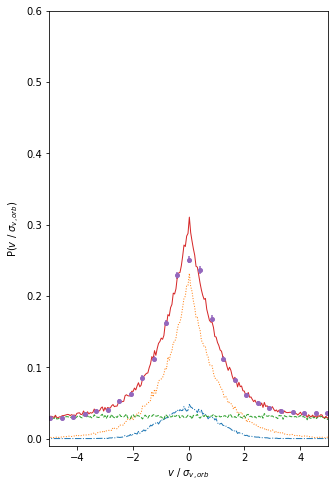

In [14]:
plot_fit(df,m.np_values(),0.8,1.0,10)

The mean value of R_edge is 2.03. (Should be roughly 1.8)
The pivot richness is 38.29. (Should be roughly 32)
The pivot redshift is 0.23. (Should be roughly 0.17)
0.0 0.05



0.05 0.1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide



0.1 0.15



0.15 0.2



0.2 0.25



0.25 0.3



0.3 0.35



0.35 0.4



0.4 0.6



0.6 0.8



0.8 1.0



1.0 1.5



1.5 2.0



2.0 2.5


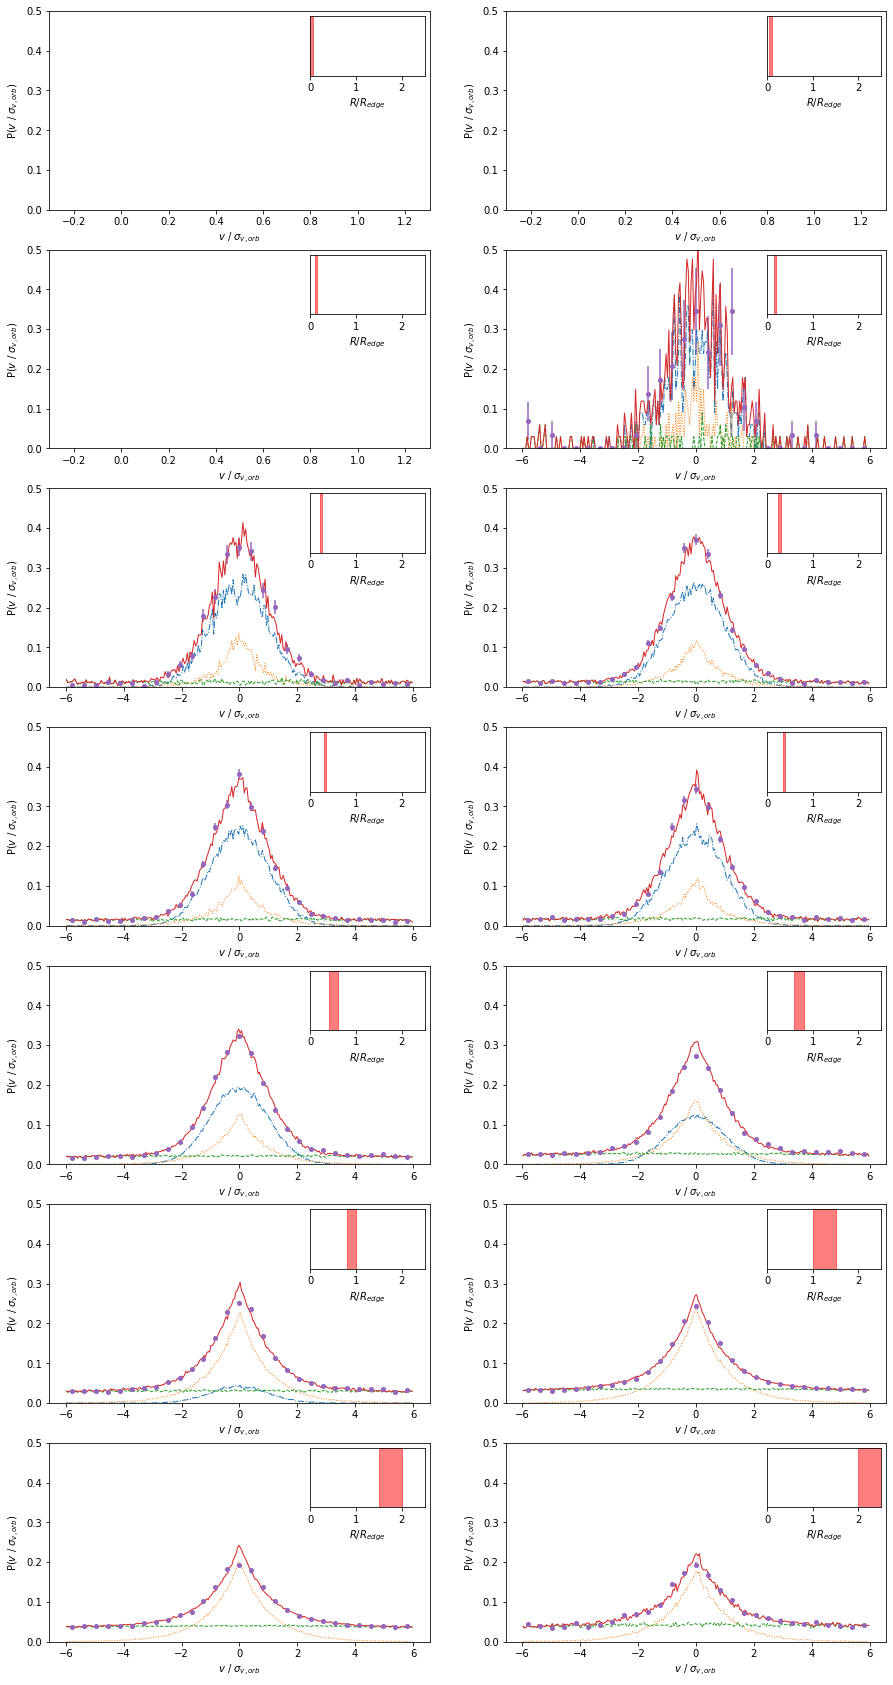

In [15]:
multi_fit(df,m.np_values(),10)

In [32]:
a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf=m.np_values()
da1, da2, db1, dc1, dc2, dsp_orb1, dsp_orb2, dalpha_orb, dsp_inf1, dsp_inf2, dalpha_inf, dsp_bg, dalpha_bg, dr_p,dalpha_r,dr_orb,dr_inf=m.np_errors()


In [33]:
print("Han model parameters")
print("a1 = %.3f" % a1,u"\u00B1", "%.3f" % da1)
print("a2 = %.3f" % a2,u"\u00B1", "%.3f" % da2)
print("b1 = %.3f" % b1,u"\u00B1", "%.3f" % db1)
print("c1 = %.3f" % c1,u"\u00B1", "%.3f" % dc1)
print("c2 = %.3f" % c2,u"\u00B1", "%.3f" % dc2)
print("sp_orb1 = %.3f" % sp_orb1,u"\u00B1", "%.3f" % dsp_orb1)
print("sp_orb2 = %.3f" % sp_orb2,u"\u00B1", "%.3f" % dsp_orb2)
print("sp_inf1 = %.3f" % sp_inf1,u"\u00B1", "%.3f" % dsp_inf1)
print("sp_inf2 = %.3f" % sp_inf2,u"\u00B1", "%.3f" % dsp_inf2)
print("sp_bg = %.3f" % sp_bg,u"\u00B1", "%.3f" % dsp_bg)
print("alpha_orb = %.3f" % alpha_orb,u"\u00B1", "%.3f" % dalpha_orb)
print("alpha_inf = %.3f" % alpha_inf,u"\u00B1", "%.3f" % dalpha_inf)
print("alpha_bg = %.3f" % alpha_bg,u"\u00B1", "%.3f" % dalpha_bg)
print("alpha_r = %.3f" % alpha_r,u"\u00B1", "%.3f" % dalpha_r)
print("r_p = %.3f" % r_p,u"\u00B1", "%.3f" % dr_p)
print("r_orb = %.3f" % r_orb,u"\u00B1", "%.3f" % dr_orb)
print("r_inf = %.3f" % r_inf,u"\u00B1", "%.3f" % dr_inf)

Han model parameters
a1 = -0.669 ± 0.029
a2 = 0.187 ± 0.025
b1 = -0.142 ± 0.007
c1 = 0.716 ± 0.141
c2 = -1.390 ± 0.117
sp_orb1 = 3.020 ± 0.203
sp_orb2 = 5.169 ± 0.182
sp_inf1 = 0.000 ± 0.054
sp_inf2 = 5.200 ± 0.062
sp_bg = 74.938 ± 5.435
alpha_orb = 0.447 ± 0.015
alpha_inf = 0.362 ± 0.019
alpha_bg = 1.000 ± 0.044
alpha_r = 0.224 ± 0.021
r_p = 1.991 ± 0.052
r_orb = 0.608 ± 0.099
r_inf = 4.996 ± 2.960


In [34]:
#Parameters that Paxton's mcmc is initialized with
ndim, nwalkers = 17,40
pos = [m.np_values() + np.random.normal(0,m.np_errors()) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike3)

In [35]:
sampler.run_mcmc(pos, 6000,progress=True); #run a 1000 length chain starting at pos

  2%|▏         | 102/6000 [05:18<5:05:33,  3.11s/it]/usr/local/lib64/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 6000/6000 [5:23:22<00:00,  3.23s/it]  


In [23]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_initial=flat_chain[max_prob_idx]

In [24]:
mcmc_initial

array([-0.67766718,  0.19779855, -0.13581956,  0.75680871, -1.44176996,
        3.28774275,  5.25017705,  0.45520403, -1.15818044,  5.35460378,
        0.37737829, 92.89534052,  1.63037127,  1.98114659,  0.26244261,
        0.57562288,  1.00262938])

The mean value of R_edge is 2.03. (Should be roughly 1.8)
The pivot richness is 38.13. (Should be roughly 32)
The pivot redshift is 0.23. (Should be roughly 0.17)
0.0 0.2



0.2 0.4



0.4 0.6



0.6 0.8



0.8 1.0



1.0 1.5



1.5 2.0



2.0 2.5


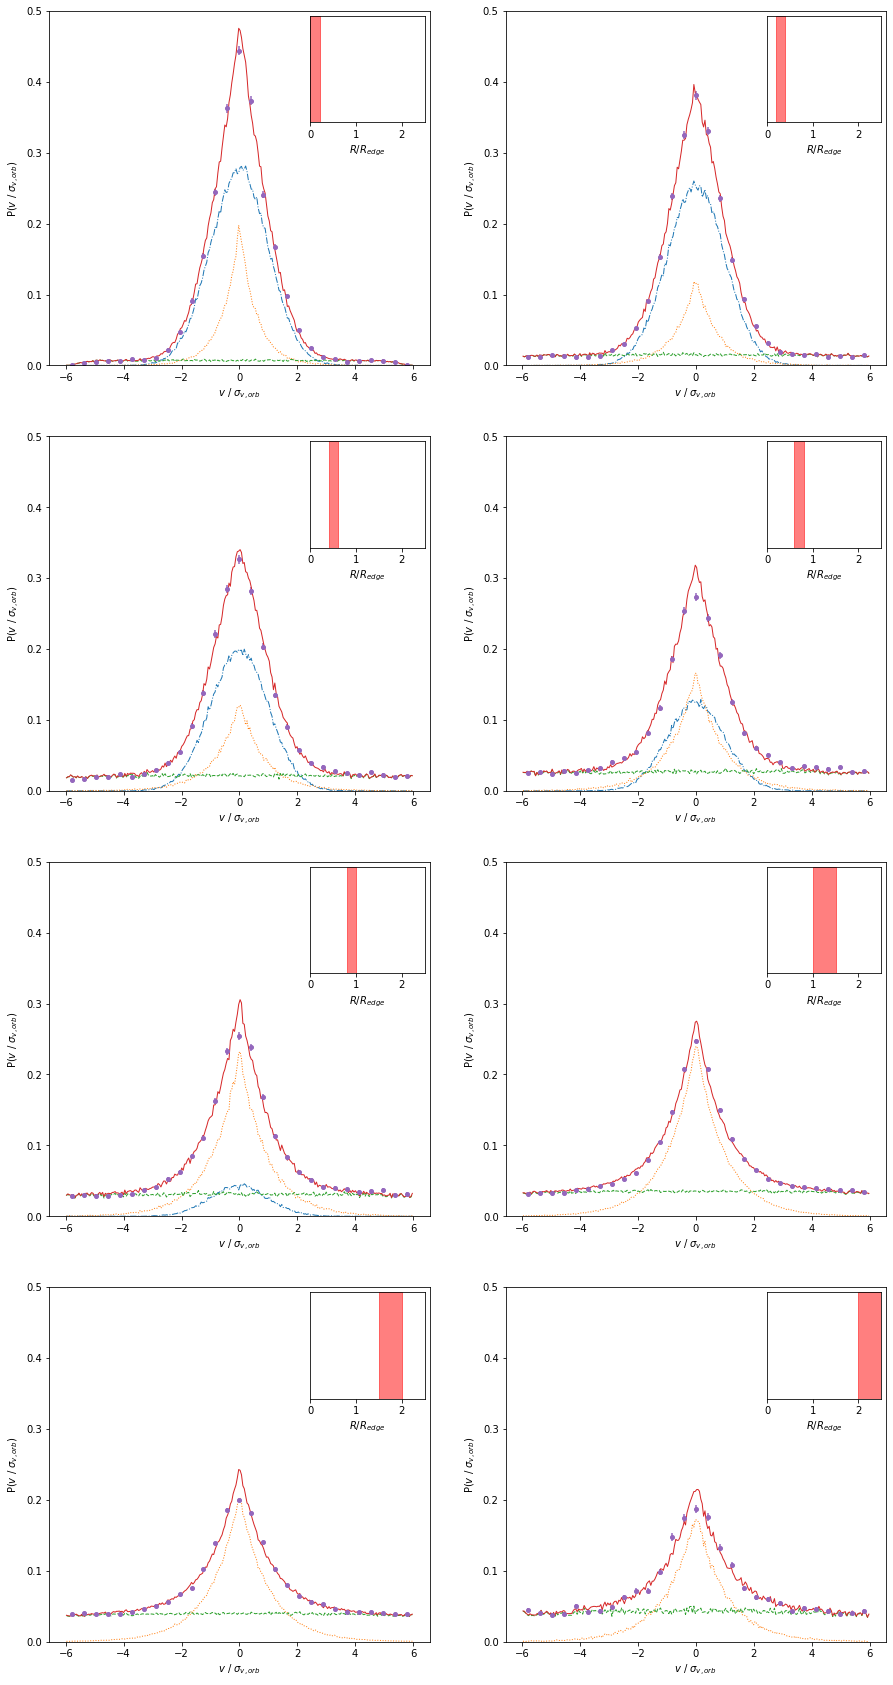

In [25]:
multi_fit(df,mcmc_initial,10)

In [26]:
flat_samples = sampler.get_chain(discard=0, thin=1, flat=True)
np.save('hanchain4000_bigsandbox.npy', flat_samples) 

In [27]:
def sample_chain(num_draws):
    """
    This function samples from the properly burned
    chain (posterior) to get a Bayesian realization
    num_draws times."""
    chain = np.load("hanchain4000_bigsandbox.npy")

    draws = np.random.randint(len(chain), size=num_draws) #the indices to draw
    return chain[draws].T #should have dimensions of (NDIM, num_draws) so each row is one variable

In [28]:
def fractions(samples):
    """
    Plotting f_vir and f_bound versus R/Rt.
    Figure 4 in the paper, left pane."""
    a1, a2, b1, c1, c2, sp_orb1, sp_orb2, alpha_orb, sp_inf1, sp_inf2, alpha_inf, sp_bg, alpha_bg, r_p,alpha_r,r_orb,r_inf = samples #unpacking parameters
    
    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations
    r_by_rt = np.tile(np.linspace(0, X_BY_XT_MAX, 100), (len(samples[0]), 1))

    #assuming all are outside x_p
    f_bound = b0[:,None] + b1[:,None]*(r_by_rt-1)
    f_vir = np.zeros_like(r_by_rt)

    lt_xt = np.where(r_by_rt <= 1)
    lt_xt = np.unique(lt_xt[1])
    #properly reassign those that are actually inside
    f_bound[:,lt_xt] = 1 + a1[:,None]*r_by_rt[:,lt_xt] + a2[:,None]*(r_by_rt[:,lt_xt]**2)
    f_vir[:,lt_xt] = c0[:,None] + c1[:,None]*r_by_rt[:,lt_xt]+ c2[:,None]*(r_by_rt[:,lt_xt]**2)

    bound_means = np.mean(f_bound, axis=0)
    bound_sigmas = np.std(f_bound, axis=0)
    bound_top = bound_means + bound_sigmas
    bound_bottom = bound_means - bound_sigmas

    vir_means = np.mean(f_vir, axis=0)
    vir_sigmas = np.std(f_vir, axis=0)
    vir_top = vir_means + vir_sigmas
    vir_bottom = vir_means - vir_sigmas
    
    bnd = plt.fill_between(r_by_rt[0], bound_top, bound_bottom)
    vir = plt.fill_between(r_by_rt[0], vir_top, vir_bottom)
    plt.legend((bnd, vir), (r"$f_{\rm{da}}$",r"$f_{\rm{orb}}$"))
    plt.ylabel(r"$f_{\rm{orb}},f_{\rm{da}}$")
    plt.ylim(0, 1)
    plt.yticks(np.linspace(0, 1, 6))
    plt.xlabel(r"$R/R_{\rm{edge}}$")
    plt.xlim(0, 2.5)
    plt.xticks(np.linspace(0, 2.5, 6))
    plt.show()

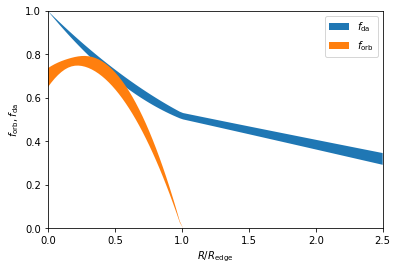

In [29]:
X_BY_XT_MAX = 2.5
samples = sample_chain(2000) #500 for a good band
fractions(samples)

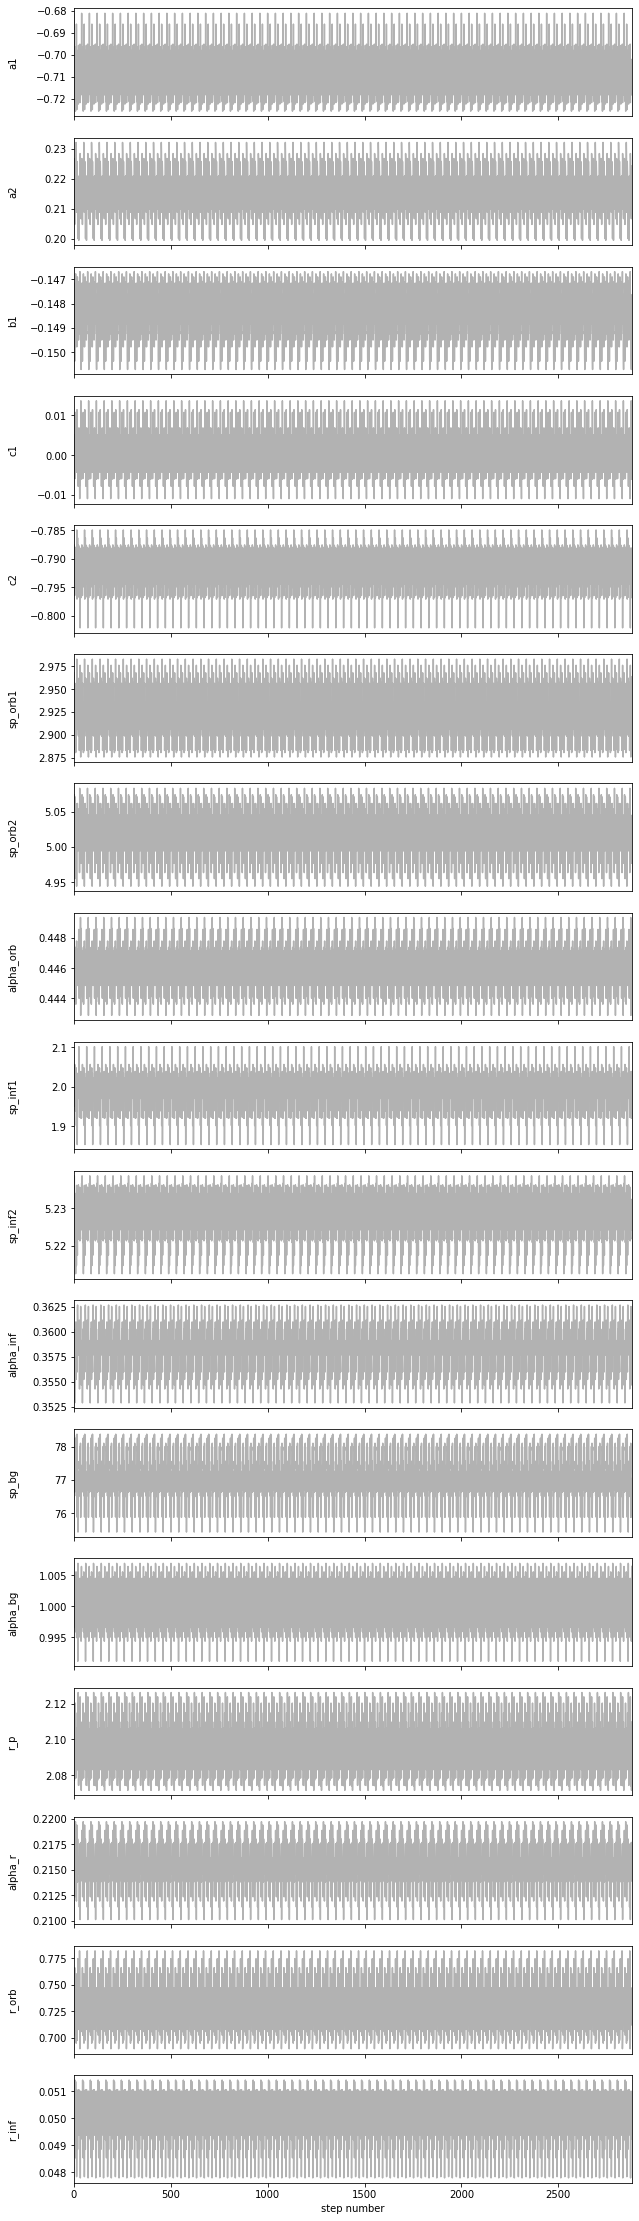

In [105]:
ndim=17
fig, axes = plt.subplots(17, figsize=(10, 40), sharex=True)
samples = sampler.get_chain(discard=0, thin=1, flat=False)
labels=['a1', 'a2', 'b1', 'c1', 'c2', 'sp_orb1', 'sp_orb2', 'alpha_orb', 'sp_inf1', 'sp_inf2', 'alpha_inf', 'sp_bg', 'alpha_bg', 'r_p','alpha_r','r_orb','r_inf']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [97]:
np.min(sampler.get_chain()[:,:,0])

-0.9170066997076378